In [1]:
import cv2,os

data_path='dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

{'without mask': 0, 'with mask': 1}
['without mask', 'with mask']
[0, 1]


In [2]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            resized=cv2.resize(gray,(img_size,img_size))
            data.append(resized)
            target.append(label_dict[category])
            
        except Exception as e:
            print('Exception:',e)

In [3]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

Using TensorFlow backend.
/Users/xela/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/xela/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/xela/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/xela/opt/anaconda3/lib/python3.7/site-pa

In [4]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
model.add(Dense(2,activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [5]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [6]:
history=model.fit(train_data,train_target,epochs=10,validation_split=0.2)


Train on 990 samples, validate on 248 samples
Epoch 1/10
990/990 [==============================] - 79s 80ms/step - loss: 0.6928 - accuracy: 0.5333 - val_loss: 0.6167 - val_accuracy: 0.6331
Epoch 2/10
990/990 [==============================] - 75s 76ms/step - loss: 0.5586 - accuracy: 0.7152 - val_loss: 0.4424 - val_accuracy: 0.8266
Epoch 3/10
990/990 [==============================] - 76s 77ms/step - loss: 0.3767 - accuracy: 0.8465 - val_loss: 0.4206 - val_accuracy: 0.8589
Epoch 4/10
990/990 [==============================] - 80s 81ms/step - loss: 0.2792 - accuracy: 0.8848 - val_loss: 0.2626 - val_accuracy: 0.9113
Epoch 5/10
990/990 [==============================] - 83s 84ms/step - loss: 0.1893 - accuracy: 0.9323 - val_loss: 0.2290 - val_accuracy: 0.9073
Epoch 6/10
990/990 [==============================] - 81s 82ms/step - loss: 0.1535 - accuracy: 0.9495 - val_loss: 0.2248 - val_accuracy: 0.9153
Epoch 7/10
990/990 [==============================] - 82s 83ms/step - loss: 0.1382 - accu

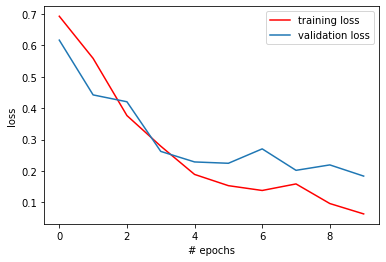

In [7]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

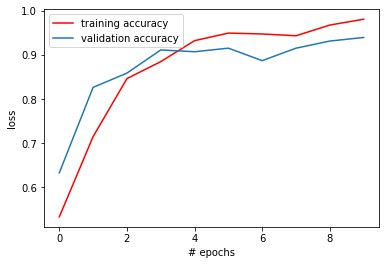

In [8]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [9]:
print(model.evaluate(test_data,test_target))

138/138 [==============================] - 3s 25ms/step
[0.13747147195365117, 0.9420289993286133]


In [30]:
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)

labels_dict={0:'NO MASK',1:'MASK'}
color_dict={0:(0,0,255),1:(0,255,0)}

In [31]:
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for x,y,w,h in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)
        print(result)
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

[[0.99283445 0.00716556]]
[[0.9936574 0.0063426]]
[[0.99380505 0.00619501]]
[[0.9942251 0.0057749]]
[[0.9939843  0.00601573]]
[[0.9946313  0.00536866]]
[[0.99496776 0.00503221]]
[[0.9941401  0.00585984]]
[[0.9936061  0.00639386]]
[[0.9944089  0.00559101]]
[[0.9935895  0.00641047]]
[[0.99562633 0.00437366]]
[[0.9953235  0.00467648]]
[[0.9944577 0.0055423]]
[[0.995171   0.00482901]]
[[0.99392277 0.00607722]]
[[0.9949897  0.00501026]]
[[0.99336773 0.00663224]]
[[0.9928227  0.00717738]]
[[0.99351466 0.00648531]]
[[0.9940356  0.00596441]]
[[0.9943322  0.00566783]]
[[0.99266726 0.00733272]]
[[0.99254495 0.00745498]]
[[0.9914048  0.00859516]]
[[0.993131 0.006869]]
[[0.99360704 0.0063929 ]]
[[0.99387085 0.00612913]]
[[0.9928451  0.00715487]]
[[0.9837944  0.01620567]]
[[0.9683887  0.03161131]]
[[0.9901113  0.00988869]]
[[0.9904545  0.00954552]]
[[0.9922524  0.00774764]]
[[0.9905257  0.00947421]]
[[0.9922092  0.00779075]]
[[0.9919565  0.00804356]]
[[0.9923437  0.00765629]]
[[0.9928462  0.0071538